In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from metric_voting.measurements import (
    cost_array,
    euclidean_cost_array,
    proportional_assignment,
    group_inefficiency,
    heuristic_worst_bloc,
)
from metric_voting.spatial_generation import *
from metric_voting.elections import *
from metric_voting.plotting import *
from metric_voting.utils import euclidean_distance

%load_ext autoreload
%autoreload 2

In [2]:
# Colors for plotting!
colors = ["#0099cd","#ffca5d","#00cd99","#99cd00","#cd0099","#9900cd","#8dd3c7",
        "#bebada","#fb8072","#80b1d3","#fdb462","#b3de69","#fccde5","#bc80bd",
        "#ccebc5","#ffed6f","#ffffb3","#a6cee3","#1f78b4","#b2df8a","#33a02c",
        "#fb9a99","#e31a1c","#fdbf6f","#ff7f00","#cab2d6","#6a3d9a","#b15928",
        "#64ffda","#00B8D4","#A1887F","#76FF03","#DCE775","#B388FF","#FF80AB",
        "#D81B60","#26A69A","#FFEA00","#6200EA",
    ]

voter_color = colors[0]
candidate_color = colors[1]
winner_color = colors[4]
bloc_color = colors[-6]
reps_color = winner_color

Once we have a spatially generated profile and have run some elections, we can then compute inefficiency measurements.

### Profile Generation:

In [3]:
# Here's a spatially generated profile! 
n = 1000
m = 20
k = 4
voter_group_sizes = [int(n/2),int(n/2)]
candidate_group_sizes = [m]

In [4]:
# Parameters for the gaussian voter distributions:
voter_params = [
    {'loc': [0, -2], 'scale': 1/3, 'size': 2},
    {'loc': [0, 2], 'scale': 1/3, 'size': 2}
]
    
# Parameters for the uniform candidate distributions. 
candidate_params = [{'low': -3, 'high': 3, 'size': 2}]

# define a distance function between voters and candidates
distance = lambda point1, point2: np.linalg.norm(point1 - point2)

# Create the group spatial generator object!
generator = GroupSpatial(
    n_voter_groups = 2,
    n_candidate_groups = 1, 
    voter_dist_fns = [np.random.normal, np.random.normal],
    voter_dist_fn_params = voter_params,
    candidate_dist_fns = [np.random.uniform],
    candidate_dist_fn_params = candidate_params,
    distance_fn = distance
)

In [5]:
# Now each call .generate() will make a profile with random candidate and voter positions
(profile,
candidate_positions,
voter_positions,
candidate_labels,
voter_labels) = generator.generate(voter_group_sizes, candidate_group_sizes)

### Running Elections

In [6]:
# Lets run a few elections to compare.
bloc_election = Bloc()
bloc_winners = bloc_election.elect(profile, k)
bloc_winners_mask = np.zeros(m, dtype = bool)
bloc_winners_mask[bloc_winners] = True

borda_election = Borda()
borda_winners = borda_election.elect(profile, k)
borda_winners_mask = np.zeros(m, dtype = bool)
borda_winners_mask[borda_winners] = True

stv_election = STV(transfer_type = 'weighted-fractional', tiebreak_type = 'fpv_random')
stv_winners = stv_election.elect(profile, k)
stv_winners_mask = np.zeros(m, dtype = bool)
stv_winners_mask[stv_winners] = True

# Measuring Results

In [7]:
# While doing this, we'll collect all the measurements in a dictionary, all results will be displayed at the end.
result_dict = {'voters' : voter_positions, 'candidates' : candidate_positions}
result_dict['Block'] = {'winners' : bloc_winners_mask}
result_dict['Borda'] = {'winners' : borda_winners_mask}
result_dict['STV'] = {'winners' : stv_winners_mask}

# For any inefficiency measurement, the procedure is made efficient by pre-computing a cost array,
# which is an (m x n) array where each entry i,j records the distance from candidate i to voter j.
cost_arr = cost_array(voter_positions, candidate_positions, distance_fn = euclidean_distance)

# Assuming distance is euclidean, the following does the same thing but much faster:
cost_arr = euclidean_cost_array(voter_positions, candidate_positions)

### Group Inefficiency

In [8]:
# To compute group inefficiencies, we can choose a bloc (in this case either bloc 0 or bloc 1):
bloc_label = 1

# And then compute inefficiencies by using
# the voter labels (as is) to tell us which bloc each voter belongs to. 
bloc_group_ineff = group_inefficiency(
    cst_array = cost_arr, 
    winner_indices = bloc_winners,
    voter_labels = voter_labels,
    bloc_label = bloc_label
)

borda_group_ineff = group_inefficiency(
    cst_array = cost_arr, 
    winner_indices = borda_winners,
    voter_labels = voter_labels,
    bloc_label = bloc_label
)

stv_group_ineff = group_inefficiency(
    cst_array = cost_arr, 
    winner_indices = stv_winners,
    voter_labels = voter_labels,
    bloc_label = bloc_label
)

# The group inefficiency computation centers around finding a proportionally 
# sized group of representatives for a given voter bloc. That is done as follows:

# finds distances only among the winning candidates
bloc_winners_cost_array = cost_arr[bloc_winners,:]

bloc_group_reps = proportional_assignment(
    cst_array = bloc_winners_cost_array,
    voter_labels = voter_labels,
    bloc_label = bloc_label,
    k = k
)
bloc_group_reps_mask = np.zeros(m, dtype = bool)
bloc_group_reps_mask[bloc_winners[bloc_group_reps]] = True


borda_group_reps = proportional_assignment(
    cst_array = cost_arr[borda_winners,:],
    voter_labels = voter_labels,
    bloc_label = bloc_label,
    k = k
)
borda_group_reps_mask = np.zeros(m, dtype = bool)
borda_group_reps_mask[borda_winners[borda_group_reps]] = True

stv_group_reps = proportional_assignment(
    cst_array = cost_arr[stv_winners,:],
    voter_labels = voter_labels,
    bloc_label = bloc_label,
    k = k
)
stv_group_reps_mask = np.zeros(m, dtype = bool)
stv_group_reps_mask[stv_winners[stv_group_reps]] = True

# record results:
result_dict['Block']['group'] = {'labels' : voter_labels, 'reps' : bloc_group_reps_mask, 'ineff' : bloc_group_ineff, 'bloc_label' : bloc_label}
result_dict['Borda']['group'] = {'labels' : voter_labels, 'reps' : borda_group_reps_mask, 'ineff' : borda_group_ineff, 'bloc_label' : bloc_label}
result_dict['STV']['group'] = {'labels' : voter_labels, 'reps' : stv_group_reps_mask, 'ineff' : stv_group_ineff, 'bloc_label' : bloc_label}

### Overall Inefficiency

In [9]:
# To compute overall inefficiencies we treat all voters as members of a single bloc.
bloc_label = 1
overall_labels = np.zeros(n) + bloc_label

# And then computing inefficiencies the same way.
bloc_ovr_ineff = group_inefficiency(
    cst_array = cost_arr, 
    winner_indices = bloc_winners,
    voter_labels = overall_labels,
    bloc_label = bloc_label
)

borda_ovr_ineff = group_inefficiency(
    cst_array = cost_arr, 
    winner_indices = borda_winners,
    voter_labels = overall_labels,
    bloc_label = bloc_label
)

stv_ovr_ineff = group_inefficiency(
    cst_array = cost_arr, 
    winner_indices = stv_winners,
    voter_labels = overall_labels,
    bloc_label = bloc_label
)

# The group inefficiency computation centers around finding a proportionally 
# sized group of representatives for a given voter bloc. That is done as follows:

# finds distances only among the winning candidates
bloc_winners_cost_array = cost_arr[bloc_winners,:]

bloc_ovr_reps = proportional_assignment(
    cst_array = bloc_winners_cost_array,
    voter_labels = overall_labels,
    bloc_label = bloc_label,
    k = k
)
bloc_ovr_reps_mask = np.zeros(m, dtype = bool)
bloc_ovr_reps_mask[bloc_winners[bloc_ovr_reps]] = True


borda_ovr_reps = proportional_assignment(
    cst_array = cost_arr[borda_winners,:],
    voter_labels = overall_labels,
    bloc_label = bloc_label,
    k = k
)
borda_ovr_reps_mask = np.zeros(m, dtype = bool)
borda_ovr_reps_mask[borda_winners[borda_ovr_reps]] = True

stv_ovr_reps = proportional_assignment(
    cst_array = cost_arr[stv_winners,:],
    voter_labels = overall_labels,
    bloc_label = bloc_label,
    k = k
)
stv_ovr_reps_mask = np.zeros(m, dtype = bool)
stv_ovr_reps_mask[stv_winners[stv_ovr_reps]] = True

# record results:
result_dict['Block']['overall'] = {'labels' : overall_labels, 'reps' : bloc_ovr_reps_mask, 'ineff' : bloc_ovr_ineff, 'bloc_label' : bloc_label}
result_dict['Borda']['overall'] = {'labels' : overall_labels, 'reps' : borda_ovr_reps_mask, 'ineff' : borda_ovr_ineff, 'bloc_label' : bloc_label}
result_dict['STV']['overall'] = {'labels' : overall_labels, 'reps' : stv_ovr_reps_mask, 'ineff' : stv_ovr_ineff, 'bloc_label' : bloc_label}

### Worst Bloc Inefficiency

In [10]:
# Given a set of winners, we may also try to search for voter blocs that give large inefficiencies.
# Results for those inefficiency values are computed here.

In [11]:
bloc_label = 1

# Greedily search for a worst voter bloc:
bloc_worst_bloc = heuristic_worst_bloc(cost_arr, bloc_winners)
bloc_worst_labels = np.ones(n) - bloc_label
bloc_worst_labels[bloc_worst_bloc] = bloc_label

# Compute inefficiency with it:
bloc_worst_ineff = group_inefficiency(
    cst_array = cost_arr, 
    winner_indices = bloc_winners,
    voter_labels = bloc_worst_labels,
    bloc_label = bloc_label
)

borda_worst_bloc = heuristic_worst_bloc(cost_arr, borda_winners)
borda_worst_labels = np.ones(n) - bloc_label
borda_worst_labels[borda_worst_bloc] = 1
borda_worst_ineff = group_inefficiency(
    cst_array = cost_arr, 
    winner_indices = borda_winners,
    voter_labels = borda_worst_labels,
    bloc_label = bloc_label
)

stv_worst_bloc = heuristic_worst_bloc(cost_arr, stv_winners)
stv_worst_labels = np.ones(n) - bloc_label
stv_worst_labels[stv_worst_bloc] = 1
stv_worst_ineff = group_inefficiency(
    cst_array = cost_arr, 
    winner_indices = stv_winners,
    voter_labels = stv_worst_labels,
    bloc_label = bloc_label
)

# The group inefficiency computation centers around finding a proportionally 
# sized group of representatives for a given voter bloc. That is done as follows:

bloc_winners_cost_array = cost_arr[bloc_winners,:]
bloc_worst_reps = proportional_assignment(
    cst_array = bloc_winners_cost_array,
    voter_labels = bloc_worst_labels,
    bloc_label = bloc_label,
    k = k
)
bloc_worst_reps_mask = np.zeros(m, dtype = bool)
bloc_worst_reps_mask[bloc_winners[bloc_worst_reps]] = True


borda_worst_reps = proportional_assignment(
    cst_array = cost_arr[borda_winners,:],
    voter_labels = borda_worst_labels,
    bloc_label = bloc_label,
    k = k
)
borda_worst_reps_mask = np.zeros(m, dtype = bool)
borda_worst_reps_mask[borda_winners[borda_worst_reps]] = True


stv_worst_reps = proportional_assignment(
    cst_array = cost_arr[stv_winners,:],
    voter_labels = stv_worst_labels,
    bloc_label = bloc_label,
    k = k
)
stv_worst_reps_mask = np.zeros(m, dtype = bool)
stv_worst_reps_mask[stv_winners[stv_worst_reps]] = True

# record results:
result_dict['Block']['worst'] = {'labels' : bloc_worst_labels, 'reps' : bloc_worst_reps_mask, 'ineff' : bloc_worst_ineff, 'bloc_label' : bloc_label}
result_dict['Borda']['worst'] = {'labels' : borda_worst_labels, 'reps' : borda_worst_reps_mask, 'ineff' : borda_worst_ineff, 'bloc_label' : bloc_label}
result_dict['STV']['worst'] = {'labels' : stv_worst_labels, 'reps' : stv_worst_reps_mask, 'ineff' : stv_worst_ineff, 'bloc_label' : bloc_label}

### Visualizing Results

Inefficiency Results are displayed in the top right corners of the plots below!

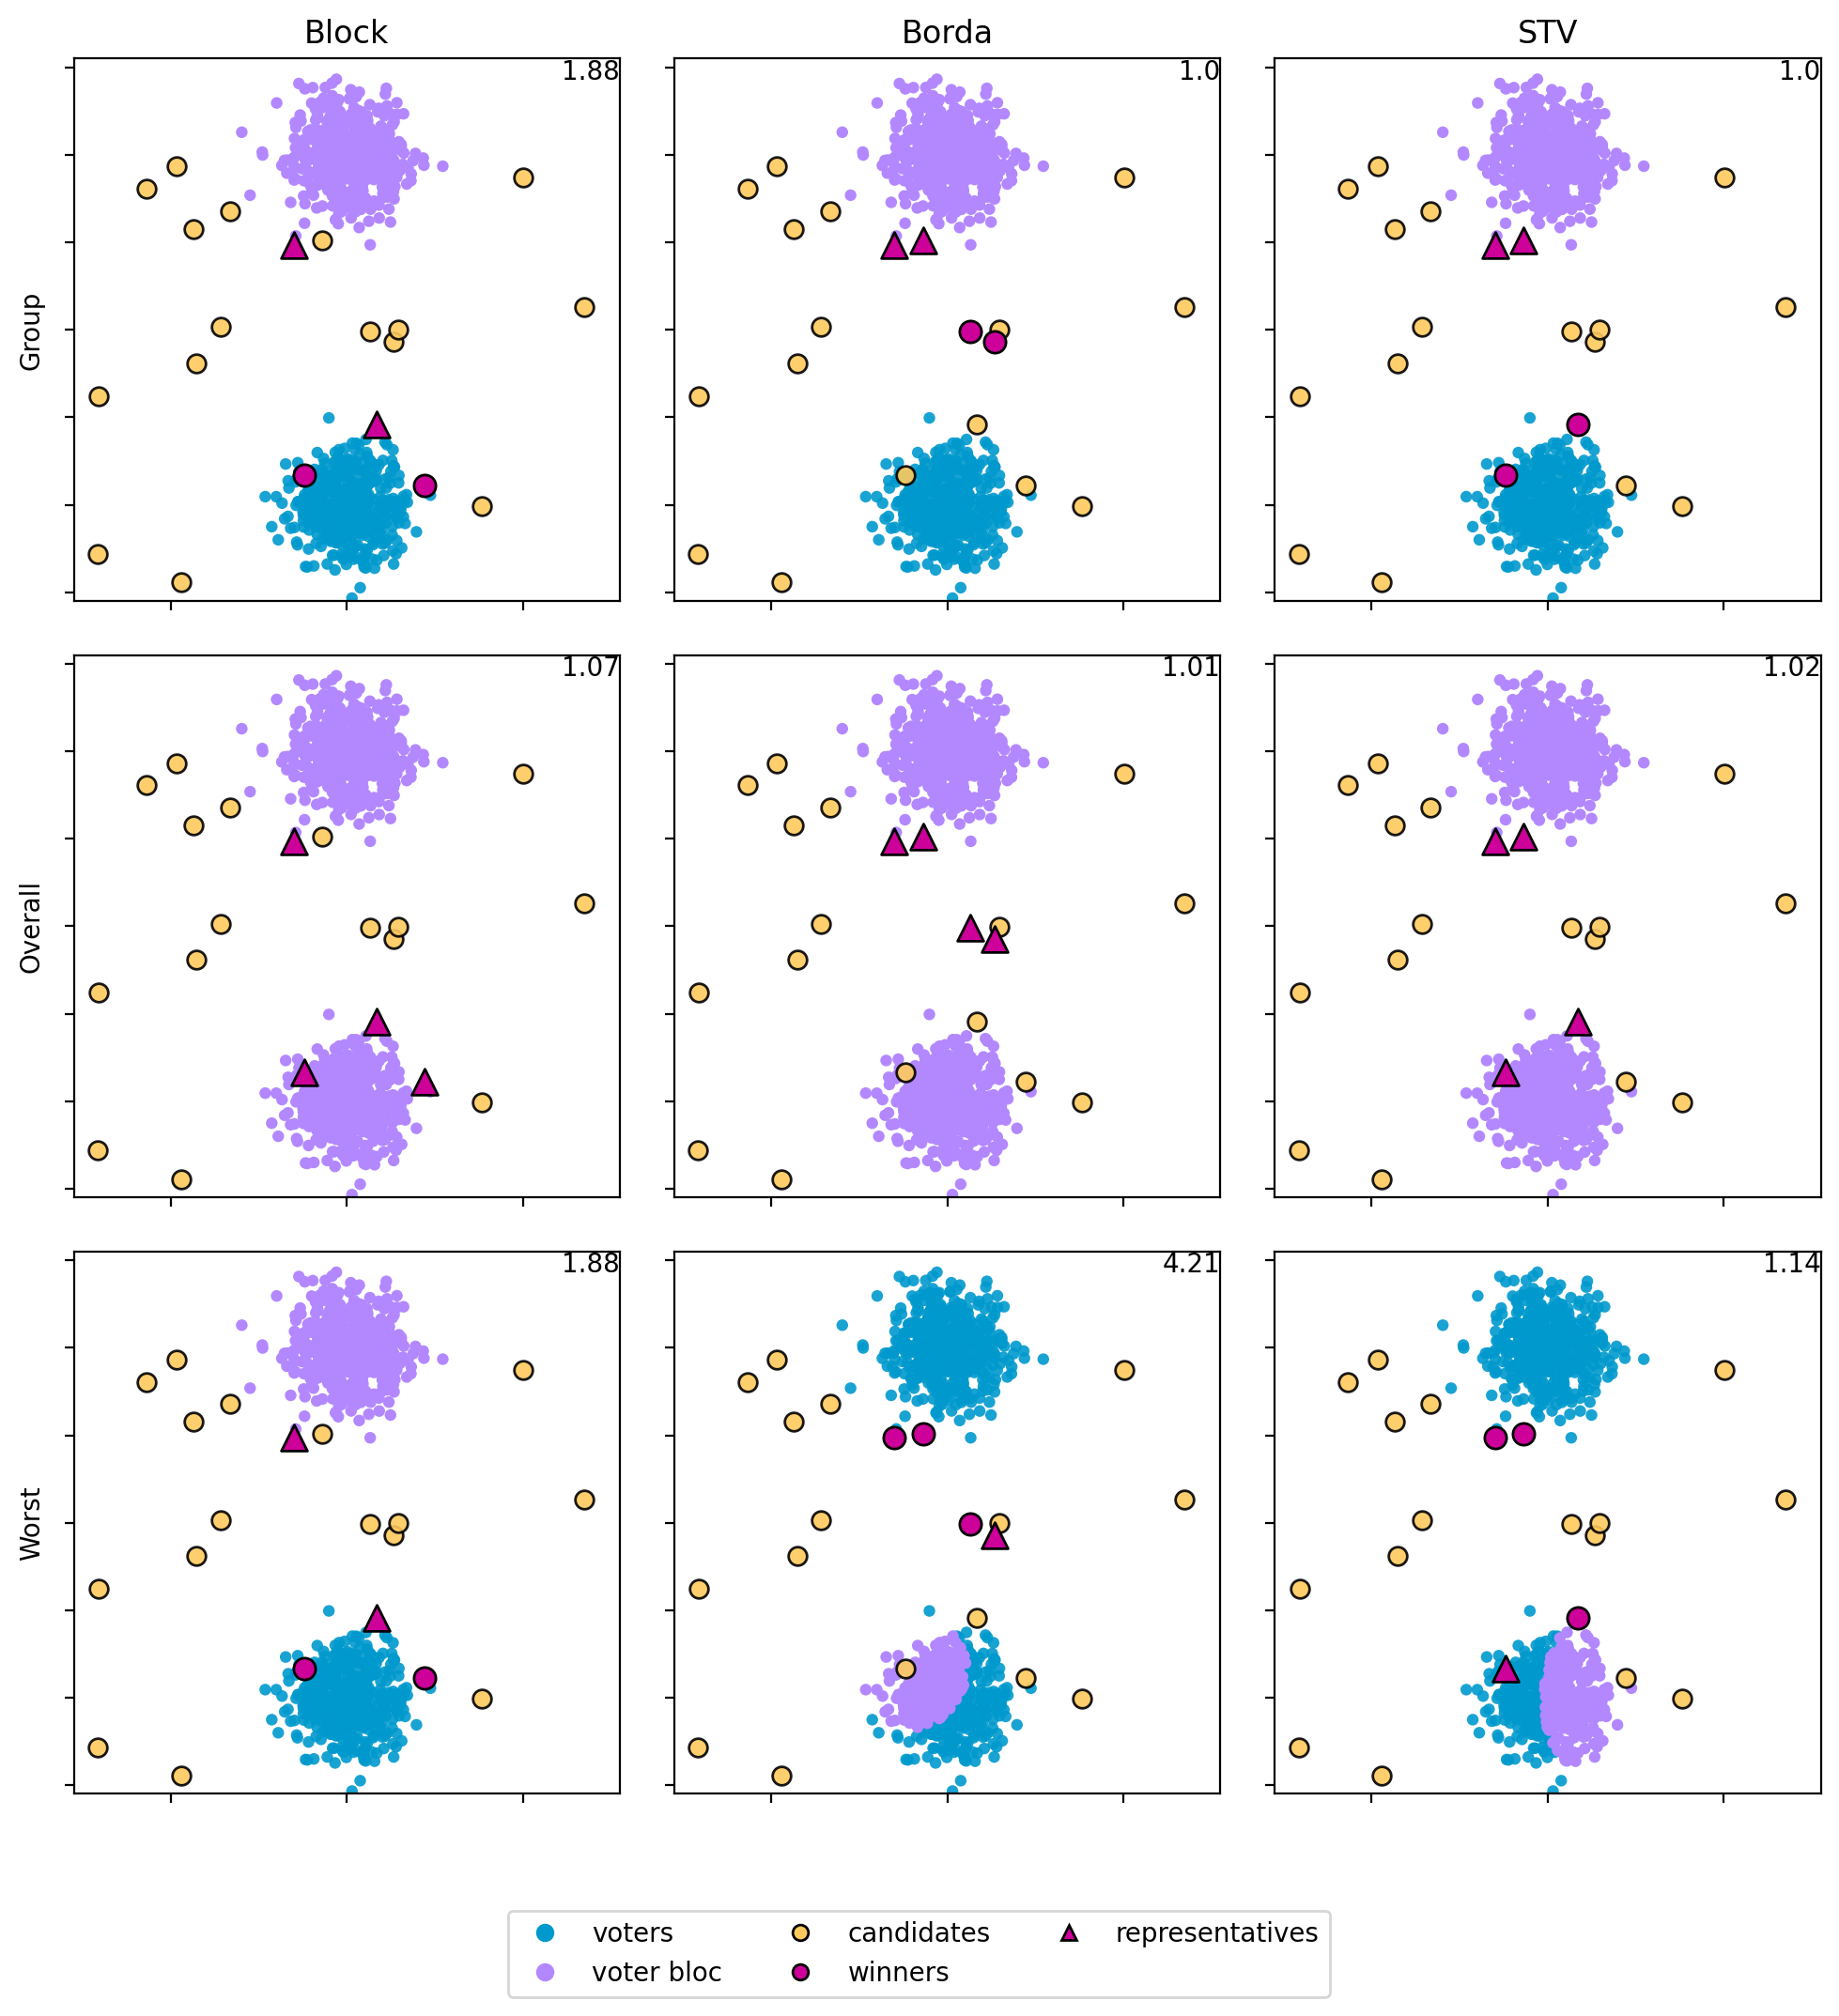

In [12]:
plot_ineff_example(
    results = result_dict,
    fig_params = {'figsize' : (12, 12), 'dpi' : 200},
    colors = [voter_color, candidate_color, winner_color, bloc_color, reps_color],
    output_file = None
)